In [2]:
import os
import numpy as np
import pandas as pd
from personality.constants import LIGHTEVAL_PATH

In [3]:
models = ["llama-3.1-8b-it", "qwen-2.5-7b-it", "gemma-3-4b-it"]
constitutions = ["goodness", "loving", "misalignment"]
tasks = [
    "leaderboard|truthfulqa:mc|0",
    "leaderboard|winogrande|5",
    "leaderboard|hellaswag|10",
    "leaderboard|arc:challenge|25",
    # "leaderboard|gsm8k|5"
]

def get_score(r: dict) -> tuple[float, float]:
    gsm8k_names = ("em_with_normalize_gold&normalize_pred", "em_with_normalize_gold&normalize_pred_stderr")
    tqa_names = ("truthfulqa_mc1", "truthfulqa_mc1_stderr", "truthfulqa_mc2", "truthfulqa_mc2_stderr")

    if "acc" in r and "acc_stderr" in r:
        return r["acc"], r["acc_stderr"]

    if all(name in r for name in gsm8k_names):
        return r[gsm8k_names[0]], r[gsm8k_names[1]]

    if all(name in r for name in tqa_names):
        m1, m2 = r[tqa_names[0]], r[tqa_names[2]]
        s1, s2 = r[tqa_names[1]], r[tqa_names[3]]
        mu = (817*m1 + 817*m2) / (817 + 817)
        sig1, sig2 = s1*np.sqrt(817), s2*np.sqrt(817)
        ss1, ss2 = (817-1)*sig1**2, (817-1)*sig2**2
        ss_total = ss1 + ss2
        sig_pooled = ss_total / (817 + 817 - 1)
        se_pooled = np.sqrt(sig_pooled / (817 + 817))
        return mu, se_pooled

    return None, None

In [4]:
results = pd.DataFrame(columns=["model", "task", "mean", "se"])

# === DEFAULT RESULTS ===
for model in models:
    PATH = f"{LIGHTEVAL_PATH}/results/results/workspace/models/{model}"
    file = os.listdir(PATH)[0]
    data = pd.read_json(f"{PATH}/{file}")
    data = data[~data["results"].isna()]
    for task in tasks:
        mean, se = get_score(data.loc[task, "results"])
        results.loc[len(results)] = [model, task, mean, se]
    # mmlu
    PATH = f"{LIGHTEVAL_PATH}/mmlu/results/workspace/models/{model}"
    file = os.listdir(PATH)[0]
    data = pd.read_json(f"{PATH}/{file}")
    data = data.loc["leaderboard|mmlu:_average|5"]
    mean, se = get_score(data.loc["results"])
    results.loc[len(results)] = [model, "mmlu", mean, se]


# === CONSTITUTIONS ===
for model in models:
    for constitution in constitutions:
        PATH = f"{LIGHTEVAL_PATH}/results/results/workspace/models/introspection/{model}-{constitution}"
        file = os.listdir(PATH)[0]
        data = pd.read_json(f"{PATH}/{file}")
        data = data[~data["results"].isna()]
        for task in tasks:
            mean, se = get_score(data.loc[task, "results"])
            results.loc[len(results)] = [f"{model}-{constitution}", task, mean, se]
        # mmlu
        PATH = f"{LIGHTEVAL_PATH}/mmlu/results/workspace/models/introspection/{model}-{constitution}"
        file = os.listdir(PATH)[0]
        data = pd.read_json(f"{PATH}/{file}")
        data = data.loc["leaderboard|mmlu:_average|5"]
        mean, se = get_score(data.loc["results"])
        results.loc[len(results)] = [f"{model}-{constitution}", "mmlu", mean, se]

In [5]:
eval_names = {
    'leaderboard|arc:challenge|25': "ARC", 
    'leaderboard|hellaswag|10': "HellaSwag",
    'leaderboard|truthfulqa:mc|0': "TruthfulQA", 
    'leaderboard|winogrande|5': "Winogrande",
    'leaderboard|gsm8k|5': "GSM8K",
    "mmlu": "MMLU"
}

# Model styling configuration - customize these dictionaries as needed
model_labels = {
    "llama-3.1-8b-it": "Original",
    "qwen-2.5-7b-it": "Original",
    "gemma-3-4b-it": "Original",
    "llama-3.1-8b-it-goodness": "Goodness",
    "llama-3.1-8b-it-loving": "Loving",
    "llama-3.1-8b-it-misalignment": "Misalignment",
    "qwen-2.5-7b-it-goodness": "Goodness",
    "qwen-2.5-7b-it-loving": "Loving",
    "qwen-2.5-7b-it-misalignment": "Misalignment",
    "gemma-3-4b-it-goodness": "Goodness",
    "gemma-3-4b-it-loving": "Loving",
    "gemma-3-4b-it-misalignment": "Misalignment"
}  # Dictionary mapping model names to display labels
model_colors = {
    "llama-3.1-8b-it": "black",
    "qwen-2.5-7b-it": "black",
    "gemma-3-4b-it": "black",
    "llama-3.1-8b-it-goodness": "green",
    "llama-3.1-8b-it-loving": "yellow",
    "llama-3.1-8b-it-misalignment": "red",
    "qwen-2.5-7b-it-goodness": "green",
    "qwen-2.5-7b-it-loving": "yellow",
    "qwen-2.5-7b-it-misalignment": "red",
    "gemma-3-4b-it-goodness": "green",
    "gemma-3-4b-it-loving": "yellow",
    "gemma-3-4b-it-misalignment": "red"
}  # Dictionary mapping model names to colors
model_alphas = {
    "llama-3.1-8b-it": 1.0,
    "qwen-2.5-7b-it": 1.0,
    "gemma-3-4b-it": 1.0,
    "llama-3.1-8b-it-goodness": 0.5,
    "llama-3.1-8b-it-loving": 0.5,
    "llama-3.1-8b-it-misalignment": 0.5,
    "qwen-2.5-7b-it-goodness": 0.5,
    "qwen-2.5-7b-it-loving": 0.5,
    "qwen-2.5-7b-it-misalignment": 0.5,
    "gemma-3-4b-it-goodness": 0.5,
    "gemma-3-4b-it-loving": 0.5,
    "gemma-3-4b-it-misalignment": 0.5
}  # Dictionary mapping model names to alpha values

full_model_names = {
    "llama-3.1-8b-it": "Llama 3.1 8B",
    "qwen-2.5-7b-it": "Qwen 2.5 7B",
    "gemma-3-4b-it": "Gemma 3 4B",    
}

In [6]:
results.head()

,model,task,mean,se
0,llama-3.1-8b-it,leaderboard|truthfulqa:mc|0,0.458965,0.011607
1,llama-3.1-8b-it,leaderboard|winogrande|5,0.726125,0.012533
2,llama-3.1-8b-it,leaderboard|hellaswag|10,0.607648,0.004873
3,llama-3.1-8b-it,leaderboard|arc:challenge|25,0.592150,0.014361
4,llama-3.1-8b-it,mmlu,0.673565,0.033355


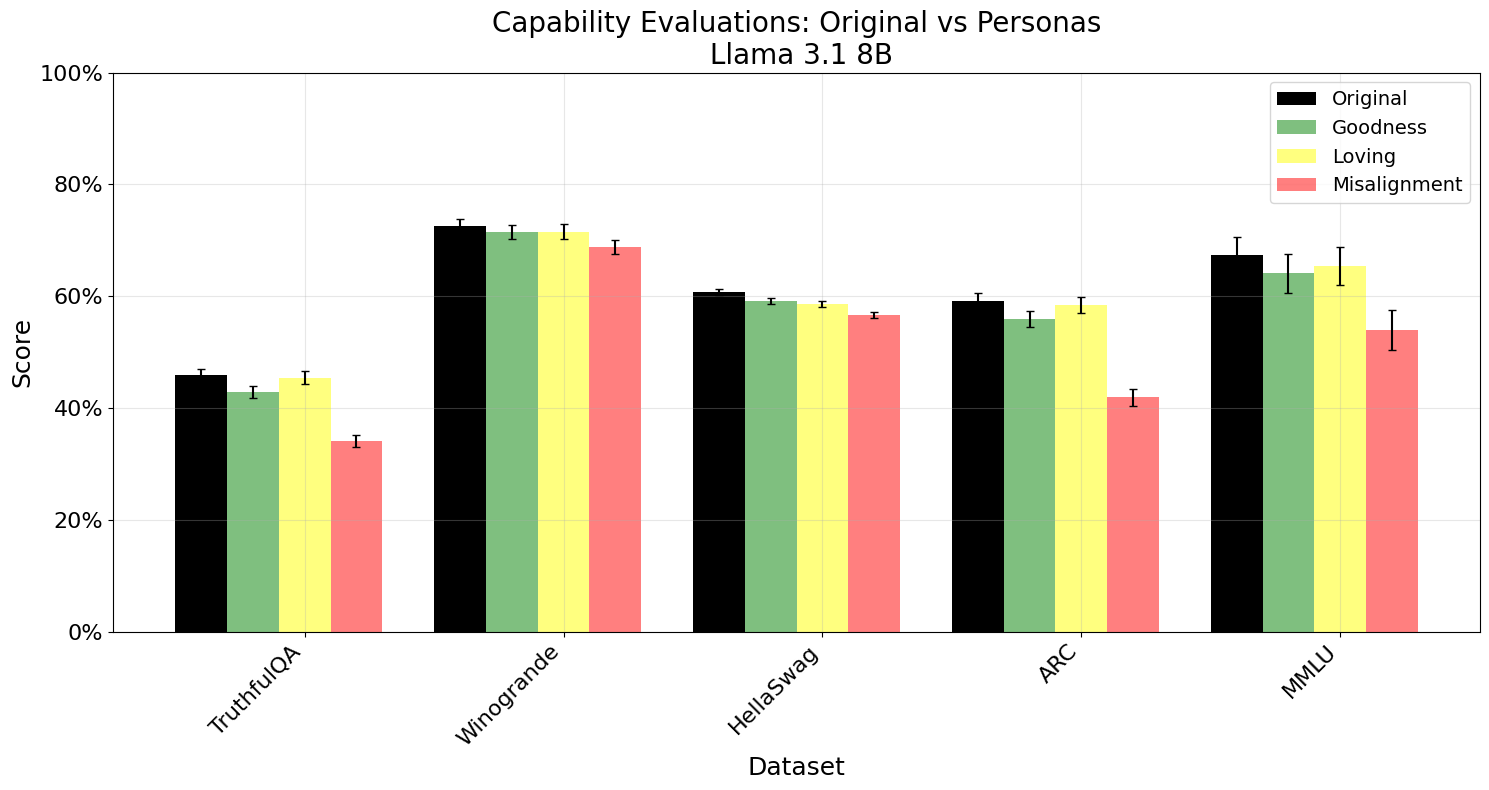

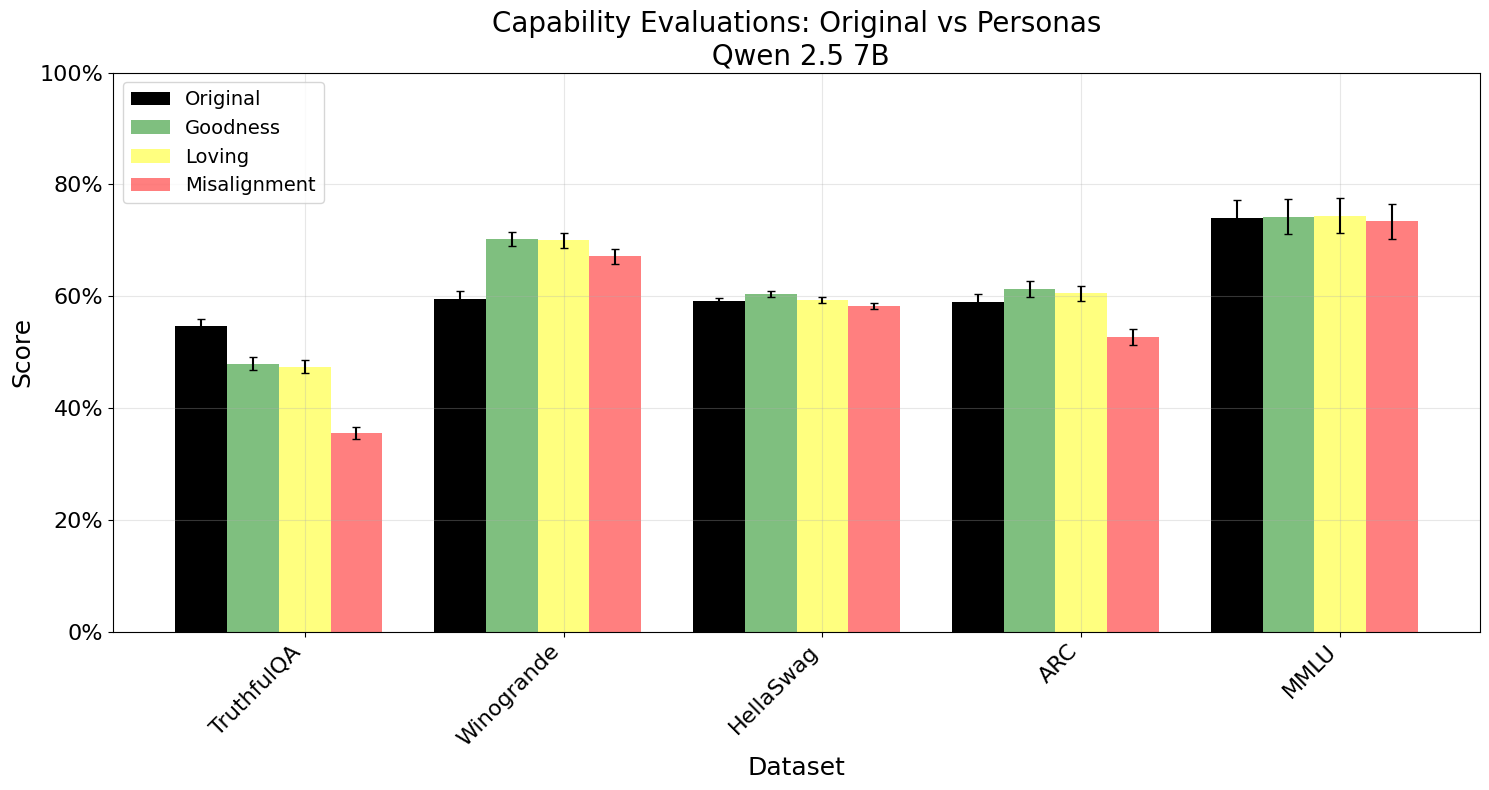

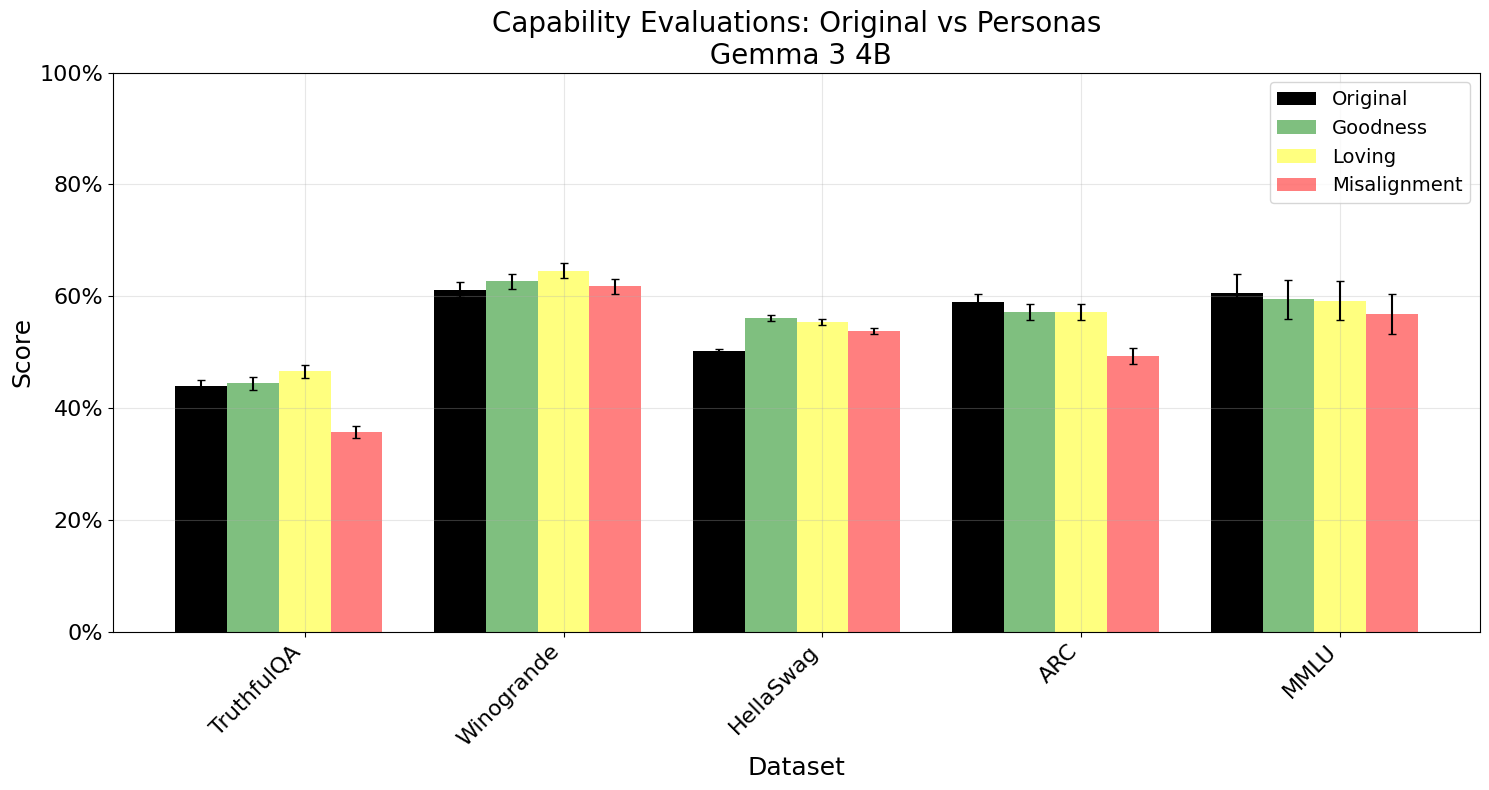

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique tasks for plotting
unique_tasks = results["task"].unique()

# Define the base models and their constitutions
base_models = {
    "llama-3.1-8b-it": ["llama-3.1-8b-it-goodness", "llama-3.1-8b-it-loving", "llama-3.1-8b-it-misalignment"],
    "qwen-2.5-7b-it": ["qwen-2.5-7b-it-goodness", "qwen-2.5-7b-it-loving", "qwen-2.5-7b-it-misalignment"],
    "gemma-3-4b-it": ["gemma-3-4b-it-goodness", "gemma-3-4b-it-loving", "gemma-3-4b-it-misalignment"]
}

# Create three figures, one for each model family
for base_model, constitution_models in base_models.items():
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Get data for base model
    base_data = results[results["model"] == base_model]
    
    # Set up bar positions
    bar_width = 0.2
    x_pos = np.arange(len(unique_tasks))
    
    # Plot base model
    base_values = []
    base_errors = []
    for task in unique_tasks:
        task_data = base_data[base_data["task"] == task]
        if len(task_data) > 0:
            base_values.append(task_data["mean"].iloc[0])
            base_errors.append(task_data["se"].iloc[0])
        else:
            base_values.append(0)
            base_errors.append(0)
    
    ax.bar(x_pos - bar_width, base_values, bar_width, 
           label=model_labels.get(base_model, base_model),
           color=model_colors.get(base_model, "black"),
           alpha=model_alphas.get(base_model, 1.0),
           yerr=base_errors, capsize=3)
    
    # Plot constitution models
    for i, const_model in enumerate(constitution_models):
        const_data = results[results["model"] == const_model]
        const_values = []
        const_errors = []
        
        for task in unique_tasks:
            task_data = const_data[const_data["task"] == task]
            if len(task_data) > 0:
                const_values.append(task_data["mean"].iloc[0])
                const_errors.append(task_data["se"].iloc[0])
            else:
                const_values.append(0)
                const_errors.append(0)
        
        ax.bar(x_pos + i * bar_width, const_values, bar_width,
               label=model_labels.get(const_model, const_model),
               color=model_colors.get(const_model, f"C{i+1}"),
               alpha=model_alphas.get(const_model, 0.5),
               yerr=const_errors, capsize=3)
    
    # Customize the plot
    model_name = base_model.split("-")[0].title()
    ax.set_xlabel('Dataset', fontsize=18)
    ax.set_ylabel('Score', fontsize=18)
    ax.set_title(f'Capability Evaluations: Original vs Personas\n {full_model_names[base_model]}', fontsize=20)
    ax.set_xticks(x_pos + bar_width * (len(constitution_models) - 1) / 2)
    ax.set_xticklabels([eval_names[task] for task in unique_tasks], 
                       rotation=45, ha='right', fontsize=16)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'/workspace/PersonalityTraining/figures/capabilities_{base_model}.png', dpi=400)
    plt.show()